<a href="https://colab.research.google.com/github/voaneves/etl-sdw2023/blob/main/Personaliza%C3%A7%C3%A3o_de_Engajamento_de_Clientes_no_Santander_usando_IA_Generativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalização de Engajamento de Clientes no Santander usando IA Generativa

Este notebook visa a implementação de uma ETL que personaliza mensagens de marketing para clientes do Santander usando IA generativa. O projeto foi desenvolvido como parte das iniciativas da Santander Dev Week 2023.

## Introdução

O cenário financeiro atual exige mais do que nunca uma abordagem personalizada na interação com os clientes. A concorrência intensa e as expectativas elevadas dos consumidores tornam imperativo que os bancos e outras instituições financeiras se envolvam com seus clientes de maneira significativa e personalizada. Neste contexto, a tecnologia de Inteligência Artificial (IA) oferece uma oportunidade sem precedentes para personalizar a comunicação e os serviços.

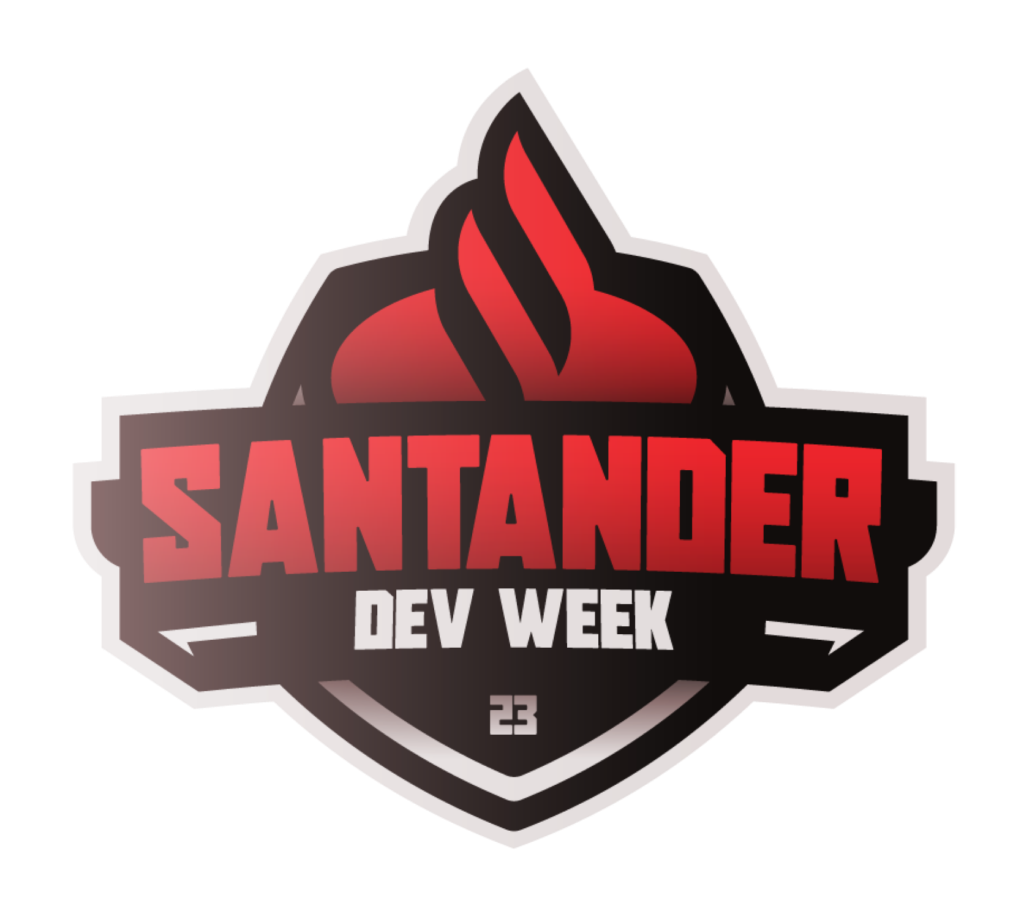

Este projeto é uma iniciativa do Santander para utilizar a IA Generativa na criação de mensagens de marketing personalizadas. Utilizando dados dos clientes e a API do Google Bard, nosso objetivo é gerar mensagens que não apenas capturam a essência das necessidades e comportamentos financeiros individuais, mas também enfatizam a importância de tomar decisões de investimento informadas.

O fluxo de trabalho é composto por várias etapas de ETL (Extração, Transformação e Carregamento), incluindo:

1. Extração de dados dos clientes a partir de uma API
2. Geração de mensagens personalizadas usando IA Generativa
3. Exibição dessas mensagens de uma forma que seja tanto atraente quanto informativa

A implementação é feita em Python, utilizando várias bibliotecas e APIs para realizar as tarefas necessárias.

<a id='Definição'></a>

## Definição do problema

**Contexto:** Você é um cientista de dados no Santander e recebeu a tarefa de envolver seus clientes de maneira mais personalizada. Seu objetivo é usar o poder da IA Generativa para criar mensagens de marketing personalizadas que serão entregues a cada cliente.

**Condições do Problema:**

1. Você recebeu uma planilha simples, em formato CSV ('SDW2023.csv'), com uma lista de IDs de usuário do banco:
  ```
  UserID
  1
  2
  3
  4
  5
  ```
2. Seu trabalho é consumir o endpoint `GET https://sdw-2023-prd.up.railway.app/users/{id}` (API da Santander Dev Week 2023) para obter os dados de cada cliente.
3. Depois de obter os dados dos clientes, você vai usar a API do ChatGPT (OpenAI) para gerar uma mensagem de marketing personalizada para cada cliente. Essa mensagem deve enfatizar a importância dos investimentos.
4. Uma vez que a mensagem para cada cliente esteja pronta, você vai enviar essas informações de volta para a API, atualizando a lista de "news" de cada usuário usando o endpoint `PUT https://sdw-2023-prd.up.railway.app/users/{id}`.

## Instação e importação das bibliotecas

Nesta seção, instalamos todas as bibliotecas necessárias, incluindo `requests`, `pandas`, `openai`, `tqdm` e `bardapi`.

In [ ]:
!pip install requests pandas openai tqdm bardapi

Depois de instaladas, podemos importar todas as bibliotecas necessárias.

In [ ]:
import requests
import pandas as pd
import time
import os
import time
import json

from tqdm import tqdm
from bardapi import Bard

## Configuração do ambiente

Começaremos dando um valor para `'_BARD_API_KEY'`, que é a key para uso do API do Google Bard. É possível encontrar mais detalhes no link do [repositório GitHub do bard-api](https://github.com/dsdanielpark/Bard-API).

In [ ]:
# Replace XXXX with the values you get from __Secure-1PSID
os.environ['_BARD_API_KEY']="aQin0JgORDXanIiTCs1rMgS5fM2AFbN2Z_96U--DEyVZZ4tsvBkWvUTk_38WdpZBVXy-Wg."

Depois disso, definimos o máximo valor de tentativas para buscar os IDs na API e o delay inicial para começar.

In [ ]:
MAX_ATTEMPTS = 3
INITIAL_DELAY = 2

## Carregamento dos IDs de Usuários

Carregamos os IDs de usuários do arquivo `SDW2023.csv` para uma lista que será usada posteriormente para buscar dados dos clientes. Este arquivo é um simples arquivo CSV com as seguintes informações:

  ```
  UserID
  1
  2
  3
  4
  5
  ```

Dessa forma, criamos a função abaixo para carregar os valores na variável `user-ids`.

In [ ]:
def load_user_ids(filename):
    return pd.read_csv(filename)['UserID']

user_ids = load_user_ids("SDW2023.csv")
print(f"User IDs loaded: {user_ids.tolist()}\n")

User IDs loaded: [1, 2, 3, 4, 5]



## Funções para Interação com a API do Santander e `user_data`

Nesta seção, apresentamos uma função crítica chamada get_user_data, que atua como a ponte entre nosso sistema e a API do Santander. Embora seja uma única função, sua importância não pode ser subestimada, pois ela serve como o principal mecanismo de coleta de dados para nossa estratégia de engajamento do cliente.

### Etapa de Exploração (Explore) em ETL

Na seção EXPLORE, onde mergulhamos profundamente nos componentes de engenharia de dados que compõem a espinha dorsal deste projeto. A personalização eficaz de mensagens de marketing requer um entendimento robusto e detalhado de cada cliente. Para isso, a coleta de dados é o primeiro e talvez o passo mais crítico.

Mas por que nomear esta seção como EXPLORE? Simples. Explorar é o ato de investigar, estudar e analisar profundamente. E é exatamente isso que pretendemos fazer aqui. Vamos explorar cada nuance da função get_user_data, desde suas entradas e operações até seu tratamento de exceções e saídas.

Esta exploração nos permite entender como os dados são extraídos (E), transformados para um formato utilizável (T), e finalmente carregados em nosso sistema (L), formando assim o nosso pipeline de ETL. Essa compreensão é vital porque qualquer erro ou ineficiência nesta etapa pode ter um efeito cascata, afetando todo o processo subsequente de geração de mensagens e engajamento do cliente.

Portanto, sem mais delongas, vamos explorar!

#### `get_user_data`

Aqui, vamos explorar a função get_user_data, que atua como a principal interface entre nosso sistema e a API de dados do Santander. Essa função foi meticulosamente projetada para ser não apenas eficiente, mas também resiliente contra uma variedade de problemas que podem surgir durante a interação com serviços externos, como APIs.

Mas por que nomear esta seção como EXPLORE? Simples. Explorar é o ato de investigar, estudar e analisar profundamente. E é exatamente isso que pretendemos fazer aqui. Vamos explorar cada nuance da função get_user_data, desde suas entradas e operações até seu tratamento de exceções e saídas.

* **Entrada:** Esta função aceita um user_id como parâmetro, que é o identificador único do cliente no sistema do banco.

* **Operação:** A função realiza uma requisição GET ao endpoint da API do Santander, especificamente https://sdw-2023-prd.up.railway.app/users/{user_id}. O objetivo é coletar informações detalhadas associadas ao ID do usuário fornecido, incluindo, mas não se limitando a, nome, saldo da conta e limite de crédito.

* **Tratamento de Exceções:** A função foi projetada para ser resiliente, empregando tratamentos de exceções para lidar com possíveis erros na requisição, como falha na rede ou indisponibilidade do serviço. Em caso de falha, a função retorna None.

* **Saída:** Se bem-sucedida, a função retorna um objeto JSON contendo todos os dados do usuário. Este objeto é posteriormente usado para personalizar as mensagens de marketing.

Esta função é um componente essencial no nosso pipeline de ETL (Extração, Transformação e Carga), focado em coletar dados valiosos dos clientes. Posteriormente, esses dados são usados para gerar mensagens personalizadas que visam aumentar o engajamento do cliente em relação a investimentos.

In [ ]:
def get_user_data(user_id):
    url = f"https://sdw-2023-prd.up.railway.app/users/{user_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()

        return response.json()
    except requests.RequestException as e:
        return None

test_response = get_user_data(1)
print(json.dumps(test_response, indent = 4))

{
    "id": 1,
    "name": "Devweekerson",
    "account": {
        "id": 1,
        "number": "01.097954-4",
        "agency": "2030",
        "balance": 624.12,
        "limit": 1000.0
    },
    "card": {
        "id": 1,
        "number": "xxxx xxxx xxxx 1111",
        "limit": 2000.0
    },
    "features": [
        {
            "id": 2,
            "icon": "https://digitalinnovationone.github.io/santander-dev-week-2023-api/icons/pay.svg",
            "description": "Pagar"
        },
        {
            "id": 3,
            "icon": "https://digitalinnovationone.github.io/santander-dev-week-2023-api/icons/transfer.svg",
            "description": "Transferir"
        },
        {
            "id": 4,
            "icon": "https://digitalinnovationone.github.io/santander-dev-week-2023-api/icons/account.svg",
            "description": "Conta Corrente"
        },
        {
            "id": 5,
            "icon": "https://digitalinnovationone.github.io/santander-dev-week-2023-api/

### Etapa de Transformação (Transform) em ETL

Já na seção TRANSFORM, temos o coração do nosso pipeline de ETL (Extração, Transformação e Carga). Depois de termos extraído com sucesso os dados relevantes sobre os clientes na seção EXPLORE, chegamos ao ponto crucial de transformar essas informações brutas em mensagens de marketing perspicazes e personalizadas. A transformação é um passo imperativo que nos permite ajustar e adaptar dados brutos em informações significativas que podem ser diretamente aplicadas às nossas estratégias de engajamento de cliente.

Aqui, vamos detalhar duas funções primordiais que lidam com essa transformação:

* **generate_custom_message:** Esta função pega os dados do usuário e os transforma em uma mensagem de marketing personalizada, focada na importância dos investimentos.

* **generate_bard_message:** Uma função que utiliza a API do Google Bard para gerar mensagens ainda mais refinadas e personalizadas, também centradas na promoção de investimentos financeiros.

Cada uma dessas funções tem suas próprias peculiaridades, parâmetros e lógicas internas que serão desvendadas. Entender como essas funções operam nos permitirá não apenas melhorar a eficiência do nosso sistema, mas também a qualidade das mensagens de engajamento geradas.

Portanto, prepare-se para uma análise aprofundada destas funções essenciais de transformação de dados.

#### `generate_custom_message`

Nessa função, através de regras, fazemos com que o cliente receba uma mensagem customizada, porém ainda não estamos usando a IA generativa.

* **Entrada:** A função recebe um objeto user_data que contém informações do usuário, como nome, saldo da conta e limite de cartão de crédito.

* **Operação:** Baseada em critérios específicos (por exemplo, saldo da conta e limite de crédito), a função cria mensagens personalizadas. Ela utiliza estruturas condicionais para adaptar a mensagem ao perfil financeiro do cliente.

* **Saída:** A função retorna uma string formatada que serve como uma mensagem de marketing personalizada para o cliente.

É aqui que transformamos dados brutos em informações acionáveis. A eficácia desta transformação tem um impacto direto na qualidade e relevância da nossa comunicação com o cliente.

In [ ]:
def generate_custom_message(user_data):
    variables = {
        "name": user_data.get('name', 'Cliente'),
        "balance": user_data.get('account', {}).get('balance', 0),
        "card_limit": user_data.get('card', {}).get('limit', 0)
    }

    if variables['balance'] < 1000:
        balance_msg = "Iniciar o investimento com um orçamento apertado é um desafio, mas não impossível."
    else:
        balance_msg = "Com um saldo financeiro saudável como o seu, as opções de investimento se multiplicam."

    if variables['card_limit'] < 1000:
        card_msg = "Dado seu limite de cartão mais baixo, aconselhamos opções de investimento de baixo risco."
    else:
        card_msg = "Com seu limite de cartão mais elevado, você tem a liberdade de explorar uma variedade de investimentos."

    return f"Olá {variables['name']}," + "\n" + f"{balance_msg}" + "\n" + f"{card_msg}" + "Investir é a chave para multiplicar seu dinheiro. Não deixe sua grana parada! Vamos investir?"

#### `generate_bard_message`

Aqui selecionamos o API do Bard para suprir os requisitos de IA Generativa. Seu uso é muito simples, conforme detalhado na função abaixo.

* **Entrada:** Similar à função anterior, esta também recebe um objeto user_data.

* **Operação:** Utiliza a API do Google Bard para gerar uma mensagem de marketing altamente personalizada e adaptada às necessidades e características do cliente.

* **Saída:** Retorna uma mensagem gerada pela API, que é usada para engajamento do cliente.

O uso desta é estratégico. Ele permite uma camada adicional de personalização e refinamento nas mensagens, tornando-as mais atraentes e relevantes para o cliente.

In [ ]:
def generate_bard_message(user_data):
    bard = Bard()
    name = user_data.get('name', 'Cliente')
    balance = user_data.get('account', {}).get('balance', 0)
    card_limit = user_data.get('card', {}).get('limit', 0)
    prompt = f"Você é um banqueiro expert, que lida com investimentos e aconselhamento. Crie uma mensagem para {name} sobre a importância dos investimentos. Considere que o saldo deles é de {balance} e o limite do cartão de crédito de {card_limit}. (responda somente com a mensagem)"

    return bard.get_answer(prompt)['content']

### Etapa de Carregamento (Load) em ETL

A fase de "Load" é a etapa final em um pipeline ETL (Extração, Transformação e Carregamento). Depois de extrair dados de várias fontes e transformá-los em um formato desejado, a etapa de "Load" é responsável por carregar esses dados transformados em um destino final.

Este destino pode ser um banco de dados, um data warehouse, ou até mesmo um dashboard para apresentação visual.

* **Persistência de Dados:** Um dos principais objetivos é garantir que os dados transformados sejam armazenados de forma segura e eficiente.

* **Performance:** As operações de carregamento devem ser otimizadas para não sobrecarregar os sistemas de destino e para garantir um processamento rápido.

* **Integridade e Consistência:** Os dados carregados devem manter a integridade e a consistência, assegurando que não haja duplicação ou perda de informação.

* **Orquestração:** Em cenários mais complexos, a etapa de carregamento também pode envolver a orquestração de várias tarefas, como carregamentos em paralelo ou sequenciais, e pode incluir lógicas condicionais para o manuseio de erros.

#### `print_colored_message` (função para visualizarmos o output)

Esta função serve como a camada de apresentação do nosso pipeline, formatando e exibindo as mensagens finais de forma amigável ao usuário.

* **Entrada:** Esta função recebe quatro parâmetros: title (o título da mensagem), custom_message (a mensagem personalizada), bard_message (mensagem gerada pelo Google Bard, se aplicável), e mType (o tipo da mensagem, usada para coloração).

* **Operação:** A função é responsável por imprimir as mensagens de forma legível e colorida no terminal. Utiliza códigos ANSI para a formatação de cores e garante que a mensagem seja impressa com uma largura fixa.

* **Saída:** A saída é uma mensagem formatada e colorida impressa diretamente no terminal.

In [ ]:
def print_colored_message(title, message = None, custom_message = None, bard_message = None, mType = "warning"):
    # ANSI escape codes for color and background
    base_bg_color = "\033[100m"  # original gray background
    color_map = {
        "warning": "\033[93m" + base_bg_color,  # yellow text, gray background
        "success": "\033[92m" + base_bg_color,  # green text, gray background
        "error": "\033[91m" + base_bg_color,    # red text, gray background
    }
    title_colors = "\033[91m" + base_bg_color  # light red text for titles
    bard_title_colors = "\033[96m" + base_bg_color  # cyan text for bard title
    colors = color_map.get(mType, "\033[0m")  # Default to no color

    # Function to print lines with fixed width and coloring
    def print_fixed_width_line(line, line_color=colors):
        print(line_color + f"{line}{' ' * (80 - len(line))}\033[0m")

    # Print the title
    print_fixed_width_line("="*80)
    print_fixed_width_line(title.center(80))
    print_fixed_width_line("="*80)

    # Se a mensagem simples e direta é fornecida, imprima-a
    if message:
        print_fixed_width_line(message)
        print_fixed_width_line("="*80)

        return

    # Print the custom message with word wrapping
    print_fixed_width_line("Resposta baseada em regras:", title_colors)
    print_fixed_width_line("")

    for line in custom_message.split("\n"):
        words = line.split()
        output_line = ""
        for word in words:
            if len(output_line) + len(word) + 1 > 80:
                print_fixed_width_line(output_line.strip())
                output_line = ""
            output_line += (word + " ")
        print_fixed_width_line(output_line.strip())

    print_fixed_width_line("")  # Add a newline at the end

    # Print the bard message with word wrapping
    print_fixed_width_line("Mensagem do Bard:", bard_title_colors)
    print_fixed_width_line("")

    for line in bard_message.split("\n"):
        words = line.split()
        output_line = ""
        for word in words:
            if len(output_line) + len(word) + 1 > 80:
                print_fixed_width_line(output_line.strip())
                output_line = ""
            output_line += (word + " ")
        print_fixed_width_line(output_line.strip())

    print_fixed_width_line("")  # Add a newline at the end

#### Funções de Processamento Principal: `process_single_user()` e `process_users()`

Aqui, definimos as funções process_single_user() e process_users() que lidam com o processamento de um único usuário e de uma lista de usuários, respectivamente.

##### `process_single_user()`

* **Entrada:** A função aceita um user_id e um retry_delay inicial como parâmetros.

* **Operação:** A função atua como uma orquestradora, chamando as funções de "Extraction" e "Transformation" para um único usuário e então passa os dados transformados para print_colored_message para apresentação.

* **Tratamento de Exceções:** Esta função foi projetada para ser resiliente, com tentativas de repetição e atrasos exponenciais em caso de falha.

* **Saída:** A saída é uma mensagem formatada impressa no terminal, indicando o sucesso ou a falha no processamento de um usuário.

##### `process_users()`

* **Entrada:** Esta função recebe uma lista de user_ids como parâmetro.

* **Operação:** Similar a process_single_user, mas opera em uma lista de usuários. Ela chama process_single_user em um loop para cada usuário na lista.

* **Tratamento de Exceções:** Se o processamento de um único usuário falha, a função imprime uma mensagem no terminal e continua para o próximo usuário na lista.

* **Saída:** Mensagens são impressas no terminal para indicar o progresso e quaisquer falhas.

Estas funções compõem parte da etapa final do nosso pipeline de ETL, responsáveis por garantir que os dados se movam eficientemente através das etapas de extração, transformação e, finalmente, carregamento para apresentação ao usuário.

In [ ]:
def process_single_user(user_id, retry_delay=INITIAL_DELAY):
    pbar = tqdm(range(MAX_ATTEMPTS), desc=f"Processing User {user_id}", leave=False)

    for attempt in pbar:
        try:
            user_data = get_user_data(user_id)

            if user_data is None:
                raise Exception("Dados do usuário não disponíveis")

            custom_message = generate_custom_message(user_data)
            bard_message = generate_bard_message(user_data)

            print_colored_message(f"Recomendações para o usuário {user_id}", custom_message=custom_message, bard_message = bard_message, "warning")

            pbar.n = MAX_ATTEMPTS
            pbar.last_print_n = MAX_ATTEMPTS
            pbar.update()
            pbar.close()

            return user_data, custom_message, bard_message
        except Exception as e:
            time.sleep(retry_delay)
            retry_delay *= 2

    pbar.close()

    return None, None, None

In [ ]:
user_messages_dict = {}

In [ ]:
def process_users(user_ids):
    last_index = len(user_ids) - 1

    for idx, user_id in enumerate(user_ids):
        user_data, custom_message, bard_message = process_single_user(user_id)

        # Only update the dictionary if user_data is not None
        user_messages_dict[user_id] = {
            'user_data': user_data,
            'custom_message': custom_message,
            'bard_message': bard_message
        }

        if user_data is None:
            if idx == last_index:
                print("\n" + f"Falha ao processar o usuário {user_id}. Lista de usuários finalizada.")
            else:
                print("\n" + f"Falha ao processar o usuário {user_id}. Continuando para o próximo.")

In [ ]:
process_users(user_ids)

                         Recomendações para o usuário 1                         
Resposta baseada em regras:                                                     
                                                                                
Olá Devweekerson,                                                               
Iniciar o investimento com um orçamento apertado é um desafio, mas não          
impossível.                                                                     
Com seu limite de cartão mais elevado, você tem a liberdade de explorar uma     
variedade de investimentos.Investir é a chave para multiplicar seu dinheiro.    
Não deixe sua grana parada! Vamos investir?                                     
                                                                                
Mensagem do Bard:                                                               
                                                                                
**Assunto: Invista seu dinhe


Falha ao processar o usuário 2. Continuando para o próximo.



Falha ao processar o usuário 3. Continuando para o próximo.



Falha ao processar o usuário 4. Continuando para o próximo.



Falha ao processar o usuário 5. Lista de usuários finalizada.


#### Funções de update dos dados: `update_user()` e `update_all_users()`

Essas duas funções em conjunto permitem que você atualize os perfis de múltiplos usuários de forma eficiente e organizada.

##### `update_user()`

A primeira é responsável por atualizar os dados de um único usuário na API.

* **Parâmetros:**
    * user_id: Identificador único do usuário.
    * user_data: Dados atuais do usuário obtidos anteriormente.
    * bard_message: Mensagem gerada pelo Bard para ser adicionada às notícias do usuário.
* **Funcionalidade:**
    * Prepara um novo item de notícia new_news_item contendo um ícone e a bard_message.
    * Adiciona este novo item à lista de "news" existente no user_data. Se "news" não existir, ele cria uma nova lista contendo apenas este item.
    * Faz uma requisição PUT para atualizar os dados do usuário na API.
* **Retorno:**
    * Retorna True se a atualização foi bem-sucedida (status code 200); caso contrário, retorna False.

##### `update_all_users()`

E esta função é responsável por atualizar todos os usuários percorrendo cada entrada no dicionário user_messages_dict.

* **Funcionalidade:**
    * Itera através de cada user_id e suas respectivas entradas em user_messages_dict.
    * Para cada usuário, ele obtém user_data e bard_message a partir do dicionário.
    * Verifica se user_data não é None. Se for None, o usuário é ignorado.
    * Chama a função update_user para atualizar os dados do usuário.
    * Imprime o status da atualização usando a função print_colored_message, que foi modificada para ser mais flexível.
* **Output:**
    * Um output colorido é exibido indicando o sucesso ou a falha na atualização de cada usuário.

In [ ]:
def update_user(user_id, user_data, bard_message):
    # URL base da API
    sdw2023_api_url = "https://sdw-2023-prd.up.railway.app"

    # Preparar a nova mensagem
    new_news_item = {
        "icon": "https://digitalinnovationone.github.io/santander-dev-week-2023-api/icons/credit.svg",
        "description": bard_message
    }

    # Adicionar a nova mensagem à lista de "news" existente
    if 'news' in user_data:
        user_data['news'].append(new_news_item)
    else:
        user_data['news'] = [new_news_item]

    # Fazer a requisição PUT para atualizar o usuário
    response = requests.put(f"{sdw2023_api_url}/users/{user_id}", json=user_data)

    # Retornar o status da operação
    return True if response.status_code == 200 else False

In [ ]:
def update_all_users():
    for user_id, user_entry in user_messages_dict.items():
        user_data = user_entry['user_data']
        bard_message = user_entry['bard_message']

        if user_data is not None:  # Skip entries where user_data is None
            success = update_user(user_id, user_data, bard_message)

            # Use a cor verde para sucesso e vermelha para falha
            message_type = "success" if success else "error"

            print_colored_message(
                title=f"Status de Atualização para o Usuário {user_id}",
                message=f"Usuário {user_id} atualizado? {success}",
                mType=message_type
            )

In [ ]:
update_all_users()

                     Status de Atualização para o Usuário 1                     
Usuário 1 atualizado? False                                                     


## Pipeline ETL da SantanderDevWeek 2023 `success`

---

**Não foi usado a API do OpenAI pois estava dando problema e agora eles cobram pay as you go**

---

O script completo atende a uma cadeia de tarefas que inclui coleta de dados, processamento, personalização de mensagens e atualização de usuários em um sistema via API. Ele foi estruturado de forma modular, o que facilita o entendimento, a manutenção e a extensão do código para outros casos de uso.

1. **Coleta de Dados:** Utiliza a função get_user_data para consultar dados dos usuários de um serviço externo. Os IDs dos usuários são carregados a partir de um CSV, tornando o processo escalável.

2. **Processamento de Mensagens:** As funções generate_custom_message e generate_bard_message são responsáveis por criar mensagens personalizadas com base nos dados coletados, utilizando tanto lógica de regras quanto inteligência artificial para gerar as mensagens.

3. **Feedback Visual:** A função print_colored_message foi projetada para ser flexível, permitindo a exibição de mensagens coloridas e formatadas tanto para mensagens simples quanto para mensagens mais complexas.

4. **Retentativas e Progresso:** Utiliza barra de progresso e lógica de retentativa para lidar com possíveis falhas e latências na coleta de dados.

5. **Atualização de Usuários:** As funções update_user e update_all_users atualizam os dados dos usuários no sistema de origem, enviando as mensagens personalizadas geradas de volta para o sistema via requisições PUT.

6. **Armazenamento Intermediário:** Um dicionário (user_messages_dict) é usado para armazenar temporariamente os dados e mensagens de cada usuário, permitindo uma atualização mais eficiente.

7. **Logging e Monitoramento:** O script fornece feedback em tempo real sobre o progresso e sucesso/falha na atualização de cada usuário.

O script serve como uma ferramenta robusta para automação e personalização em escala, com potencial para melhorar significativamente a experiência do usuário e a eficiência operacional. É um excelente ponto de partida para desenvolvimentos futuros e adaptações em contextos diversos.